In [1]:
import os
import sys
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Tao thu muc luu tru tren Drive
PROJECT_PATH = '/content/drive/MyDrive/NLP_Assignment_2025'
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
DATA_SAVE_PATH = os.path.join(PROJECT_PATH, 'data')

if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)
if not os.path.exists(DATA_SAVE_PATH):
    os.makedirs(DATA_SAVE_PATH)

print(f"Directory setup complete. Data and models will be saved to: {PROJECT_PATH}")

# 3. Cai dat thu vien bo tro
!pip install -q pyvi spacy torchtext
!python -m spacy download en_core_web_sm

Mounted at /content/drive
Directory setup complete. Data and models will be saved to: /content/drive/MyDrive/NLP_Assignment_2025
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 142.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import os
import tarfile
import sys

def download_real_data():
    data_dir = 'data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # URL file nen tu GitHub (Mirror cua dataset IWSLT'15)
    url = "https://github.com/stefan-it/nmt-en-vi/raw/master/data/train-en-vi.tgz"
    tgz_path = os.path.join(data_dir, "train-en-vi.tgz")

    # File dich can co sau khi giai nen
    expected_vi = os.path.join(data_dir, "train.vi")
    expected_en = os.path.join(data_dir, "train.en")

    # Kiem tra neu file da ton tai thi khong tai lai
    if os.path.exists(expected_vi) and os.path.exists(expected_en):
        if os.path.getsize(expected_vi) > 0:
            print("Data already exists. Skipping download.")
            return

    print("Downloading data from GitHub...")
    exit_code = os.system(f"wget -q {url} -O {tgz_path}")

    if exit_code != 0 or not os.path.exists(tgz_path) or os.path.getsize(tgz_path) < 1000:
        raise RuntimeError("ERROR: Failed to download data. Link might be broken.")

    print("Extracting data...")
    try:
        with tarfile.open(tgz_path, "r:gz") as tar:
            tar.extractall(path=data_dir)
    except Exception as e:
        raise RuntimeError(f"ERROR: Failed to extract tar file. Details: {e}")

    if not os.path.exists(expected_vi) or not os.path.exists(expected_en):
         raise RuntimeError("ERROR: Extraction finished but train.vi or train.en not found.")

    print(f"Data downloaded and extracted successfully to: {data_dir}")

# Chay ham download
try:
    download_real_data()
except RuntimeError as e:
    print(e)
    sys.exit(1) # Dung chuong trinh neu loi

Extracting data...


/tmp/ipython-input-4242858198.py:33: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=data_dir)


Data downloaded and extracted successfully to: data


In [3]:
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_head == 0, "d_model must be divisible by n_head"
        self.d_head = d_model // n_head
        self.n_head = n_head
        self.d_model = d_model

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        Q = self.w_q(query).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        K = self.w_k(key).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        V = self.w_v(value).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.d_head)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e9)

        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(attention, V)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.fc_out(x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        _src = self.self_attn(src, src, src, src_mask)
        src = self.norm1(src + self.dropout(_src))
        _src = self.ffn(src)
        src = self.norm2(src + self.dropout(_src))
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.cross_attn = MultiHeadAttention(d_model, n_head)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg = self.self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))
        _trg = self.cross_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))
        _trg = self.ffn(trg)
        trg = self.norm3(trg + self.dropout(_trg))
        return trg

class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layer, n_head, d_ff, dropout, max_len):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        src = self.dropout(self.pos_encoding(self.embedding(src)))
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layer, n_head, d_ff, dropout, max_len):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)])
        self.fc_out = nn.Linear(d_model, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        trg = self.dropout(self.pos_encoding(self.embedding(trg)))
        for layer in self.layers:
            trg = layer(trg, enc_src, trg_mask, src_mask)
        output = self.fc_out(trg)
        return output

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, d_model=256, n_head=8, n_layer=3, d_ff=512, dropout=0.1, max_len=100, src_pad_idx=1, trg_pad_idx=1):
        super(Transformer, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        # Gọi class Encoder và Decoder riêng biệt
        self.encoder = Encoder(src_vocab_size, d_model, n_layer, n_head, d_ff, dropout, max_len)
        self.decoder = Decoder(trg_vocab_size, d_model, n_layer, n_head, d_ff, dropout, max_len)

    def make_src_mask(self, src):
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=trg.device)).bool()
        return trg_pad_mask & trg_sub_mask

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # Dùng self.encoder thay vì gọi trực tiếp layers
        enc_src = self.encoder(src, src_mask)

        # Dùng self.decoder
        output = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output

Building Vocabulary...
Vocab Size: Vi=12517, En=29345
Saving vocabulary to /content/drive/MyDrive/NLP_Assignment_2025/data...
Creating DataLoader...
Reading files: data/train.vi and data/train.en
Successfully loaded 133166 sentence pairs.
Training on: cuda
Trainable parameters: 22,212,001
Starting training for 10 epochs...
Epoch: 01 | Time: 4m 48s | Loss: 5.3729 | PPL: 215.4828
New best model saved to: /content/drive/MyDrive/NLP_Assignment_2025/checkpoints/transformer_best.pt
Epoch: 02 | Time: 4m 52s | Loss: 4.8181 | PPL: 123.7266
New best model saved to: /content/drive/MyDrive/NLP_Assignment_2025/checkpoints/transformer_best.pt
Epoch: 03 | Time: 4m 52s | Loss: 4.5913 | PPL: 98.6223
New best model saved to: /content/drive/MyDrive/NLP_Assignment_2025/checkpoints/transformer_best.pt
Epoch: 04 | Time: 4m 53s | Loss: 4.4147 | PPL: 82.6600
New best model saved to: /content/drive/MyDrive/NLP_Assignment_2025/checkpoints/transformer_best.pt
Epoch: 05 | Time: 4m 52s | Loss: 4.2362 | PPL: 69.144

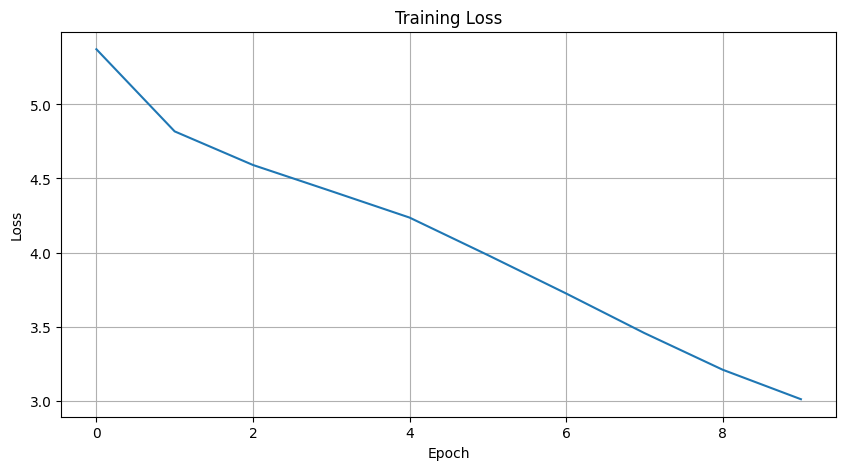

Training finished successfully.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import time
import math
import os
import matplotlib.pyplot as plt

# --- 0. ĐỊNH NGHĨA CLASS DỮ LIỆU (BỊ THIẾU) ---
# Các class này thuộc trách nhiệm Người 1, cần định nghĩa để code chạy được
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.itos = {0: "<unk>", 1: "<pad>", 2: "<sos>", 3: "<eos>"}
        self.stoi = {"<unk>": 0, "<pad>": 1, "<sos>": 2, "<eos>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self): return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in sentence.lower().strip().split():
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        return [self.stoi.get(token, self.stoi["<unk>"]) for token in text.lower().strip().split()]

class TranslationDataset(Dataset):
    def __init__(self, src_file, trg_file, src_vocab, trg_vocab, max_len=100):
        self.src_data = []
        self.trg_data = []
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len = max_len

        print(f"Reading files: {src_file} and {trg_file}")
        with open(src_file, 'r', encoding='utf-8') as f: src_lines = f.readlines()
        with open(trg_file, 'r', encoding='utf-8') as f: trg_lines = f.readlines()

        if len(src_lines) == 0:
            raise ValueError(f"ERROR: Source file is empty: {src_file}")

        for src, trg in zip(src_lines, trg_lines):
            src, trg = src.strip(), trg.strip()
            if src and trg:
                self.src_data.append(src)
                self.trg_data.append(trg)

        print(f"Successfully loaded {len(self.src_data)} sentence pairs.")

    def __len__(self): return len(self.src_data)

    def __getitem__(self, index):
        src_text = self.src_data[index]
        trg_text = self.trg_data[index]
        src_indices = [SOS_IDX] + self.src_vocab.numericalize(src_text) + [EOS_IDX]
        trg_indices = [SOS_IDX] + self.trg_vocab.numericalize(trg_text) + [EOS_IDX]

        if len(src_indices) > self.max_len: src_indices = src_indices[:self.max_len]
        if len(trg_indices) > self.max_len: trg_indices = trg_indices[:self.max_len]
        return torch.tensor(src_indices), torch.tensor(trg_indices)

def get_collate_fn(pad_idx):
    def collate_fn(batch):
        src_batch, trg_batch = [], []
        for src_item, trg_item in batch:
            src_batch.append(src_item)
            trg_batch.append(trg_item)
        src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=pad_idx, batch_first=True)
        trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, padding_value=pad_idx, batch_first=True)
        return src_batch, trg_batch
    return collate_fn

# --- 1. CONFIG & UTILS ---
# Đảm bảo các biến toàn cục tồn tại
if 'PROJECT_PATH' not in globals():
    PROJECT_PATH = '/content/drive/MyDrive/NLP_Assignment_2025'
    CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
    DATA_SAVE_PATH = os.path.join(PROJECT_PATH, 'data')

def train_one_epoch(model, iterator, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)

        trg_input = trg[:, :-1] # Bỏ token cuối
        trg_output = trg[:, 1:] # Bỏ token đầu

        optimizer.zero_grad()
        output = model(src, trg_input)

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg_output = trg_output.contiguous().view(-1)

        loss = criterion(output, trg_output)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed = end_time - start_time
    return int(elapsed / 60), int(elapsed % 60)

# --- 2. SETUP DATA & VOCAB ---
train_vi_path = 'data/train.vi'
train_en_path = 'data/train.en'

# Kiểm tra file
if not os.path.exists(train_vi_path):
    if os.path.exists(os.path.join('data', 'train.vi')): # Check thư mục con
        train_vi_path = os.path.join('data', 'train.vi')
        train_en_path = os.path.join('data', 'train.en')
    else:
        raise FileNotFoundError(f"ERROR: File {train_vi_path} not found. Please run Cell 2 again.")

print("Building Vocabulary...")
with open(train_vi_path, 'r', encoding='utf-8') as f: src_raw = f.readlines()
with open(train_en_path, 'r', encoding='utf-8') as f: trg_raw = f.readlines()

src_vocab = Vocabulary(freq_threshold=2)
trg_vocab = Vocabulary(freq_threshold=2)
src_vocab.build_vocabulary(src_raw)
trg_vocab.build_vocabulary(trg_raw)
print(f"Vocab Size: Vi={len(src_vocab)}, En={len(trg_vocab)}")

# SAVE VOCAB TO DRIVE
print(f"Saving vocabulary to {DATA_SAVE_PATH}...")
if not os.path.exists(DATA_SAVE_PATH): os.makedirs(DATA_SAVE_PATH)
torch.save(src_vocab, os.path.join(DATA_SAVE_PATH, 'src_vocab.pth'))
torch.save(trg_vocab, os.path.join(DATA_SAVE_PATH, 'trg_vocab.pth'))

# CREATE DATALOADER
print("Creating DataLoader...")
train_dataset = TranslationDataset(train_vi_path, train_en_path, src_vocab, trg_vocab)
train_iterator = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=get_collate_fn(PAD_IDX))

# --- 3. SETUP MODEL & TRAIN ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {DEVICE}")

INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
D_MODEL = 256
N_HEAD = 8
N_LAYER = 3
D_FF = 512
DROPOUT = 0.1
MAX_LEN = 150

# Khởi tạo model
model = Transformer(INPUT_DIM, OUTPUT_DIM, D_MODEL, N_HEAD, N_LAYER, D_FF, DROPOUT, MAX_LEN, PAD_IDX, PAD_IDX).to(DEVICE)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights)

print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

N_EPOCHS = 10
CLIP = 1
train_losses = []
best_loss = float('inf')

print(f"Starting training for {N_EPOCHS} epochs...")

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train_one_epoch(model, train_iterator, optimizer, criterion, CLIP, DEVICE)

    end_time = time.time()
    mins, secs = epoch_time(start_time, end_time)

    train_losses.append(train_loss)
    print(f'Epoch: {epoch+1:02} | Time: {mins}m {secs}s | Loss: {train_loss:.4f} | PPL: {math.exp(train_loss):.4f}')

    # Save Checkpoint
    if not os.path.exists(CHECKPOINT_PATH): os.makedirs(CHECKPOINT_PATH)
    checkpoint_name = f'transformer_epoch_{epoch+1}.pt'
    save_path = os.path.join(CHECKPOINT_PATH, checkpoint_name)
    torch.save(model.state_dict(), save_path)

    # Save Best Model
    if train_loss < best_loss:
        best_loss = train_loss
        best_save_path = os.path.join(CHECKPOINT_PATH, 'transformer_best.pt')
        torch.save(model.state_dict(), best_save_path)
        print(f"New best model saved to: {best_save_path}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
graph_path = os.path.join(PROJECT_PATH, 'loss_graph.png')
plt.savefig(graph_path)
print(f"Loss graph saved to: {graph_path}")
plt.show()

print("Training finished successfully.")